# An Introduction to High-Dimensional Time Series Forecasting with Neural Networks

**Note**: for a high-level overview on this topic, check out my [blog post](https://jeddy92.github.io/JEddy92.github.io/ts_seq2seq_intro/). 

This notebook aims to demonstrate in python/keras code how a sequence-to-sequence neural network can be built for the purpose of time series forecasting. In particular, it explores the "high-dimensional" time series setting, where a high quantity (100,000s+) of series must be forecast simultaneously. This is where a modern technique like neural networks can truly shine vs. more traditional series-specific methods like ARIMA - we don't need to create a massive set of fine-tuned, series specific parameters.

In this notebook I'll be using a dataset of daily wikipedia web page traffic, available [here on Kaggle](https://www.kaggle.com/c/web-traffic-time-series-forecasting/data). The corresponding competition called for forecasting 60 days into the future, but for this demonstration we'll simplify to forecasting only 14 days. However, we will use all of the series history available in "train_1.csv" for the encoding stage of the model. 

Our goal here is not to create an optimal model - check out later notebooks in this series for that. Instead, the focus is on showing a relatively simple implimentation of the core seq2seq architecture.

Here's a section breakdown of this notebook -- enjoy!

**1. Loading and Previewing the Data**   
**2. Formatting the Data for Modeling**  
**3. Building the Model - Training Architecture**  
**4. Building the Model - Inference Architecture**  
**5. Generating and Plotting Predictions**

## 1. Loading and Previewing the Data 

First thing's first, let's load up the data and get a quick feel for it (reminder that the dataset is available [here](https://www.kaggle.com/c/web-traffic-time-series-forecasting/data)). 

Note that there are a good number of NaN values in the data that don't disambiguate missing from zero. For the sake of simplicity in this tutorial, we'll naively fill these with 0 later on.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()

df = pd.read_csv('../data/train_1.csv')
df.head()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,32.0,63.0,15.0,26.0,14.0,20.0,22.0,19.0,18.0,20.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,17.0,42.0,28.0,15.0,9.0,30.0,52.0,45.0,26.0,20.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,3.0,1.0,1.0,7.0,4.0,4.0,6.0,3.0,4.0,17.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,32.0,10.0,26.0,27.0,16.0,11.0,17.0,19.0,10.0,11.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,48.0,9.0,25.0,13.0,3.0,11.0,27.0,13.0,36.0,10.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145063 entries, 0 to 145062
Columns: 551 entries, Page to 2016-12-31
dtypes: float64(550), object(1)
memory usage: 609.8+ MB


In [4]:
data_start_date = df.columns[1]
data_end_date = df.columns[-1]
print('Data ranges from %s to %s' % (data_start_date, data_end_date))

Data ranges from 2015-07-01 to 2016-12-31


We can define a function that lets us visualize some random webpage series as below. For the sake of smoothing out the scale of traffic across different series, we apply a log1p transformation before plotting - i.e. take $\log(1+x)$ for each value $x$ in a series.

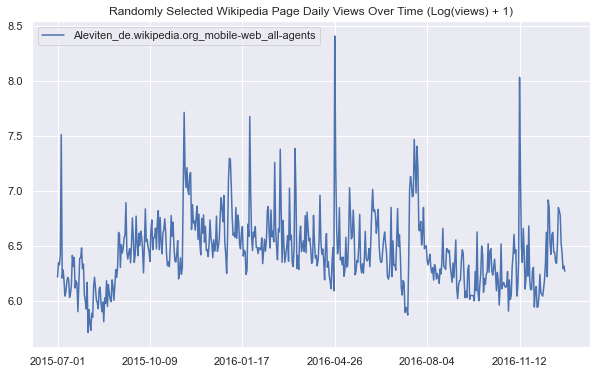

In [5]:
def plot_random_series(df, n_series):
    
    sample = df.sample(n_series, random_state=8)
    page_labels = sample['Page'].tolist()
    series_samples = sample.loc[:,data_start_date:data_end_date]
    
    plt.figure(figsize=(10,6))
    
    for i in range(series_samples.shape[0]):
        np.log1p(pd.Series(series_samples.iloc[i]).astype(np.float64)).plot(linewidth=1.5)
    
    plt.title('Randomly Selected Wikipedia Page Daily Views Over Time (Log(views) + 1)')
    plt.legend(page_labels)
    
plot_random_series(df, 1)

## 2. Formatting the Data for Modeling 

Sadly we can't just throw the dataframe we've created into keras and let it work its magic. Instead, we have to set up a few data transformation steps to extract nice numpy arrays that we can pass to keras. But even before doing that, we have to know how to appropriately partition the time series into encoding and decoding (prediction) intervals for the purposes of training and validation.

We'll use a style of **walk-forward validation**, where our validation set spans the same time-range as our training set, but shifted forward in time (in this case by 14 days). This way, we simulate how our model will perform on unseen data that comes in the future. 

[Artur Suilin](https://github.com/Arturus/kaggle-web-traffic/blob/master/how_it_works.md) has created a very nice image that visualizes this validation style and contrasts it with traditional validation. I highly recommend checking out his entire repo, as he's implemented a truly state of the art (and competition winning) seq2seq model on this data set. 

![architecture](images/ArturSuilin_validation.png)

### Train and Validation Series Partioning

We need to create 4 sub-segments of the data:

    1. Train encoding period
    2. Train decoding period (train targets, 14 days)
    3. Validation encoding period
    4. Validation decoding period (validation targets, 14 days)
    
We'll do this by finding the appropriate start and end dates for each segment. Starting from the end of the data we've loaded, we'll work backwards to get validation and training prediction intervals. Then we'll work forward from the start to get training and validation encoding intervals. 

In [6]:
from datetime import timedelta

pred_steps = 14
pred_length=timedelta(pred_steps)

first_day = pd.to_datetime(data_start_date) 
last_day = pd.to_datetime(data_end_date)

val_pred_start = last_day - pred_length + timedelta(1)
val_pred_end = last_day

train_pred_start = val_pred_start - pred_length
train_pred_end = val_pred_start - timedelta(days=1) 

print(first_day,last_day)
print(val_pred_start,val_pred_end)
print(train_pred_start,train_pred_end)

2015-07-01 00:00:00 2016-12-31 00:00:00
2016-12-18 00:00:00 2016-12-31 00:00:00
2016-12-04 00:00:00 2016-12-17 00:00:00


In [8]:
now_time = '20230219 '
test_date = now_time[0:4]+ '_' + now_time[4:6] + '_' + now_time[6:8]
test_date

'2023_02_19'

In [12]:
now_time = '2023-02-19 14:00:00'
pd_name = now_time[0:4]+now_time[5:7] + now_time[8:10] + now_time[11:13]+ now_time[14:16]+ now_time[17:19]
pd_name

'20230219140000'

In [15]:

dt = {'index': [10, 20, 30, 40], 'times': [100, 200, 300, 400], }

df = pd.DataFrame(dt)

df

,index,times
0,10,100
1,20,200
2,30,300
3,40,400


In [17]:
dt = {'index': [10, 20, 30, 40], }
df2 = pd.DataFrame(dt)
df2

,index
0,10
1,20
2,30
3,40


In [26]:

df.add(df2['index'], axis = 0)

TypeError: must be str, not int

In [7]:
print('Train encoding:', train_enc_start, '-', train_enc_end)
print('Train prediction:', train_pred_start, '-', train_pred_end, '\n')
print('Val encoding:', val_enc_start, '-', val_enc_end)
print('Val prediction:', val_pred_start, '-', val_pred_end)

print('\nEncoding interval:', enc_length.days)
print('Prediction interval:', pred_length.days)

Train encoding: 2015-07-01 00:00:00 - 2016-12-03 00:00:00
Train prediction: 2016-12-04 00:00:00 - 2016-12-17 00:00:00 

Val encoding: 2015-07-15 00:00:00 - 2016-12-17 00:00:00
Val prediction: 2016-12-18 00:00:00 - 2016-12-31 00:00:00

Encoding interval: 522
Prediction interval: 14


### Keras Data Formatting

Now that we have the time segment dates, we'll define the functions we need to extract the data in keras friendly format. Here are the steps:

* Pull the time series into an array, save a date_to_index mapping as a utility for referencing into the array 
* Create function to extract specified time interval from all the series 
* Create functions to transform all the series. 
    - Here we smooth out the scale by taking log1p and de-meaning each series using the encoder series mean, then reshape to the **(n_series, n_timesteps, n_features) tensor format** that keras will expect. 
    - Note that if we want to generate true predictions instead of log scale ones, we can easily apply a reverse transformation at prediction time. 

In [8]:
date_to_index = pd.Series(index=pd.Index([pd.to_datetime(c) for c in df.columns[1:]]),
                          data=[i for i in range(len(df.columns[1:]))])

series_array = df[df.columns[1:]].values
series_array.shape

(145063, 550)

In [9]:
df.columns[1:]

Index(['2015-07-01', '2015-07-02', '2015-07-03', '2015-07-04', '2015-07-05',
       '2015-07-06', '2015-07-07', '2015-07-08', '2015-07-09', '2015-07-10',
       ...
       '2016-12-22', '2016-12-23', '2016-12-24', '2016-12-25', '2016-12-26',
       '2016-12-27', '2016-12-28', '2016-12-29', '2016-12-30', '2016-12-31'],
      dtype='object', length=550)

In [ ]:

def get_time_block_series(series_array, date_to_index, start_date, end_date):
    
    inds = date_to_index[start_date:end_date]
    return series_array[:,inds]

def transform_series_encode(series_array):
    
    series_array = np.log1p(np.nan_to_num(series_array)) # filling NaN with 0
    series_mean = series_array.mean(axis=1).reshape(-1,1) 
    series_array = series_array - series_mean
    series_array = series_array.reshape((series_array.shape[0],series_array.shape[1], 1))
    
    return series_array, series_mean

def transform_series_decode(series_array, encode_series_mean):
    
    series_array = np.log1p(np.nan_to_num(series_array)) # filling NaN with 0
    series_array = series_array - encode_series_mean
    series_array = series_array.reshape((series_array.shape[0],series_array.shape[1], 1))
    
    return series_array

## 3. Building the Model - Training Architecture

This architecture / code is adapted from the excellent [keras blog introduction to seq2seq](https://blog.keras.io/a-ten-minute-introduction-to-sequence-to-sequence-learning-in-keras.html). Chollet's piece shows the more classic seq2seq application to machine translation, but the steps we need to take here are very similar.

Note that we'll use **teacher forcing**, where during training, the true series values (lagged by one time step) are fed as inputs to the decoder. Intuitively, we are trying to teach the NN how to condition on previous time steps to predict the next. At prediction time, the true values in this process will be replaced by predicted values for each previous time step.

This image created by [Artur Suilin](https://github.com/Arturus/kaggle-web-traffic/blob/master/how_it_works.md) captures the architecture we use well (we use LSTM instead of GRU).

![architecture](images/ArturSuilin_encoder-decoder.png)

In [10]:
from keras.models import Model
from keras.layers import Input, LSTM, Dense
from keras.optimizers import Adam

latent_dim = 50 # LSTM hidden units
dropout = .20 

# Define an input series and encode it with an LSTM. 
encoder_inputs = Input(shape=(None, 1)) 
encoder = LSTM(latent_dim, dropout=dropout, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)

# We discard `encoder_outputs` and only keep the final states. These represent the "context"
# vector that we use as the basis for decoding.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
# This is where teacher forcing inputs are fed in.
decoder_inputs = Input(shape=(None, 1)) 

# We set up our decoder using `encoder_states` as initial state.  
# We return full output sequences and return internal states as well. 
# We don't use the return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, dropout=dropout, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)

decoder_dense = Dense(1) # 1 continuous output at each timestep
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

Using TensorFlow backend.
D:\SoftInstall\Anaconda3\envs\tensorflow13\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
D:\SoftInstall\Anaconda3\envs\tensorflow13\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
D:\SoftInstall\Anaconda3\envs\tensorflow13\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
D:\SoftInstall\Anaconda3\e

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [11]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, 1)      0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, None, 1)      0                                            
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, 50), (None,  10400       input_1[0][0]                    
__________________________________________________________________________________________________
lstm_2 (LSTM)                   [(None, None, 50), ( 10400       input_2[0][0]                    
                                                                 lstm_1[0][1]                     
          

With our training architecture defined, we're ready to train the model! This will take some time if you're not running fancy hardware (read GPU). We'll leverage the transformer utility functions we defined earlier, and train using mean absolute error loss. 

For better results, you could try using more data, adjusting the hyperparameters, tuning the learning rate and number of epochs, etc.  

In [12]:
first_n_samples = 20000
batch_size = 2**11
epochs = 100

# sample of series from train_enc_start to train_enc_end  
encoder_input_data = get_time_block_series(series_array, date_to_index, 
                                           train_enc_start, train_enc_end)[:first_n_samples]
encoder_input_data, encode_series_mean = transform_series_encode(encoder_input_data)

# sample of series from train_pred_start to train_pred_end 
decoder_target_data = get_time_block_series(series_array, date_to_index, 
                                            train_pred_start, train_pred_end)[:first_n_samples]
decoder_target_data = transform_series_decode(decoder_target_data, encode_series_mean)
encoder_input_data.shape

(20000, 522, 1)

In [13]:

# lagged target series for teacher forcing
decoder_input_data = np.zeros(decoder_target_data.shape)
decoder_input_data[:,1:,0] = decoder_target_data[:,:-1,0]
decoder_input_data[:,0,0] = encoder_input_data[:,-1,0]

model.compile(Adam(), loss='mean_absolute_error')
history = model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
                     batch_size=batch_size,
                     epochs=epochs,
                     validation_split=0.2)

Instructions for updating:
Use tf.cast instead.
Train on 16000 samples, validate on 4000 samples
Epoch 1/100
16000/16000 [==============================] - 22s 1ms/step - loss: 0.6647 - val_loss: 0.5281
Epoch 2/100
16000/16000 [==============================] - 19s 1ms/step - loss: 0.5670 - val_loss: 0.4158
Epoch 3/100
16000/16000 [==============================] - 19s 1ms/step - loss: 0.4853 - val_loss: 0.3665
Epoch 4/100
16000/16000 [==============================] - 19s 1ms/step - loss: 0.4532 - val_loss: 0.3415
Epoch 5/100
16000/16000 [==============================] - 19s 1ms/step - loss: 0.4394 - val_loss: 0.3245
Epoch 6/100
16000/16000 [==============================] - 19s 1ms/step - loss: 0.4191 - val_loss: 0.3099
Epoch 7/100
16000/16000 [==============================] - 19s 1ms/step - loss: 0.4091 - val_loss: 0.3034
Epoch 8/100
16000/16000 [==============================] - 19s 1ms/step - loss: 0.3972 - val_loss: 0.3001
Epoch 9/100
16000/16000 [==============================

It's typically a good idea to look at the convergence curve of train/validation loss.

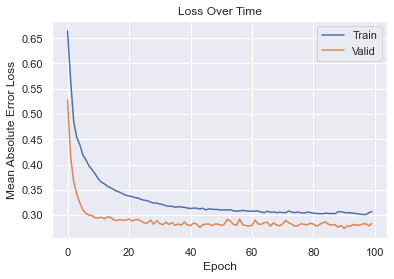

In [14]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error Loss')
plt.title('Loss Over Time')
plt.legend(['Train','Valid'])

## 4. Building the Model - Inference Architecture

Not done with architecture yet! We need to use keras to define an inference model that draws on our neural network to actually generate predictions. In a nutshell, this architecture starts by encoding the input series, then generates predictions one by one. The decoder gets fed initial state vectors from the encoder, but the state vectors are then iteratively updated as the decoder generates a prediction for each time step.   

In [15]:
# from our previous model - mapping encoder sequence to state vectors
encoder_model = Model(encoder_inputs, encoder_states)

# A modified version of the decoding stage that takes in predicted target inputs
# and encoded state vectors, returning predicted target outputs and decoder state vectors.
# We need to hang onto these state vectors to run the next step of the inference loop.
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]

decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model([decoder_inputs] + decoder_states_inputs,
                      [decoder_outputs] + decoder_states)

def decode_sequence(input_seq):
    
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, 1))
    
    # Populate the first target sequence with end of encoding series pageviews
    target_seq[0, 0, 0] = input_seq[0, -1, 0]

    # Sampling loop for a batch of sequences - we will fill decoded_seq with predictions
    # (to simplify, here we assume a batch of size 1).

    decoded_seq = np.zeros((1,pred_steps,1))
    
    for i in range(pred_steps):
        
        output, h, c = decoder_model.predict([target_seq] + states_value)
        
        decoded_seq[0,i,0] = output[0,0,0]

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, 1))
        target_seq[0, 0, 0] = output[0,0,0]

        # Update states
        states_value = [h, c]

    return decoded_seq

## 5. Generating and Plotting Predictions 

Now we have everything we need to generate predictions for encoder/target series pairs that we didn't train on. We'll pull out our set of validation encoder/target series (recall that these are shifted forward in time). Then using a plotting utility function, we can look at the tail end of the encoder series, the true target series, and the predicted target series. This gives us a feel for how our predictions are doing.  

In [16]:
encoder_input_data = get_time_block_series(series_array, date_to_index, val_enc_start, val_enc_end)
encoder_input_data, encode_series_mean = transform_series_encode(encoder_input_data)

decoder_target_data = get_time_block_series(series_array, date_to_index, val_pred_start, val_pred_end)
decoder_target_data = transform_series_decode(decoder_target_data, encode_series_mean)

In [17]:
def predict_and_plot(encoder_input_data, decoder_target_data, sample_ind, enc_tail_len=50):

    encode_series = encoder_input_data[sample_ind:sample_ind+1,:,:] 
    pred_series = decode_sequence(encode_series)
    
    encode_series = encode_series.reshape(-1,1)
    pred_series = pred_series.reshape(-1,1)   
    target_series = decoder_target_data[sample_ind,:,:1].reshape(-1,1) 
    
    encode_series_tail = np.concatenate([encode_series[-enc_tail_len:],target_series[:1]])
    x_encode = encode_series_tail.shape[0]
    
    plt.figure(figsize=(10,6))   
    
    plt.plot(range(1,x_encode+1),encode_series_tail)
    plt.plot(range(x_encode,x_encode+pred_steps),target_series,color='orange')
    plt.plot(range(x_encode,x_encode+pred_steps),pred_series,color='teal',linestyle='--')
    
    plt.title('Encoder Series Tail of Length %d, Target Series, and Predictions' % enc_tail_len)
    plt.legend(['Encoding Series','Target Series','Predictions'])

Generating some plots as below, we can see that our predictions manage to effectively anticipate some trends in the data and can understand when certain patterns should remain fairly steady. 

However, our predictions look overly conservative and clearly fail to capture a lot of the choppy variability in the data. We would likely stand to gain from increasing the sample size for training, tuning the network architecture/hyperparameters, and training for more epochs.  

**Check out the next notebook in this series** for fancier architectures and more expressive predictions.  

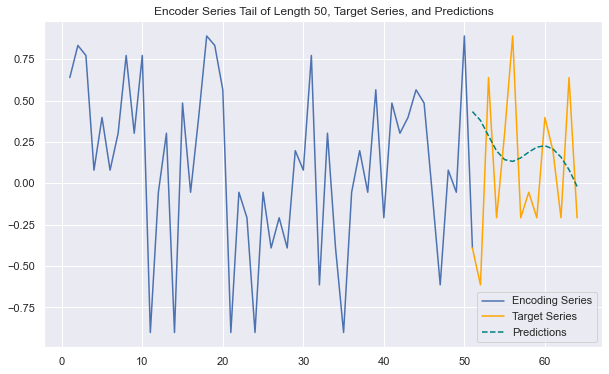

In [18]:
predict_and_plot(encoder_input_data, decoder_target_data, 100)

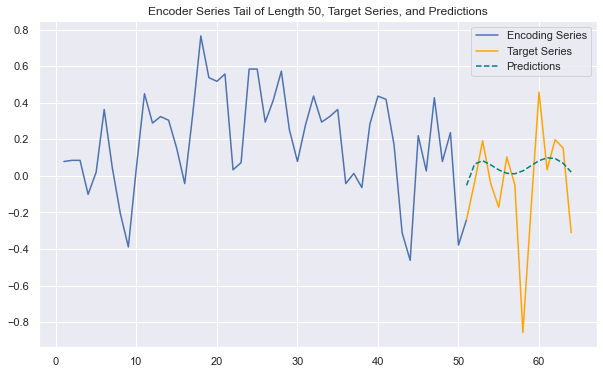

In [19]:
predict_and_plot(encoder_input_data, decoder_target_data, 6007)

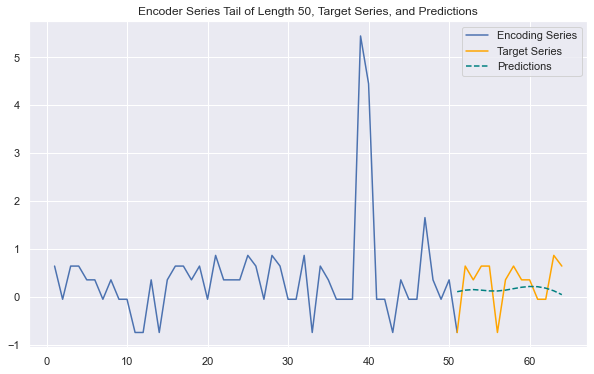

In [20]:
predict_and_plot(encoder_input_data, decoder_target_data, 33000)